In [1]:
import lymph
import pandas as pd
import scipy as sp
import numpy as np
import numpy as np
from scipy.optimize import minimize
import pprint

In [2]:
graph_dict_II_III = {
    ('tumor', 'T')  : ['II', 'III'], 
    ('lnl'  , 'II') : ['III'], 
    ('lnl'  , 'III'): []
}

graph_dict_II_III_IV = {
    ('tumor', 'T')  : ['II', 'III', 'IV'], 
    ('lnl'  , 'II') : ['III'], 
    ('lnl'  , 'III'): ['IV'], 
    ('lnl'  , 'IV') : []
}
# named_params = ['ipsi_TtoII_spread_ext1', 
#                 'ipsi_TtoIII_spread_ext1',
#                 'contra_TtoII_spread_ext1',
#                 'contra_TtoII_spread_ext2',
#                 'contra_TtoII_spread_ext3',
#                 'contra_TtoIII_spread_ext1',
#                 'contra_TtoIII_spread_ext2',
#                 'contra_TtoIII_spread_ext3',
#                 'IItoIII_spread',
#                 'mixing1',
#                 'mixing2',
#                 'mixing3']


csv_file_path = r"usz_reduced_cohort.csv"
dataset_distance_cohorts_oropharynx = pd.read_csv(csv_file_path, header = [0,1,2])
model = lymph.models.Midline(graph_dict = graph_dict_II_III_IV,
                             use_mixing = True,
                             use_cohorts = True,
                             use_midext_evo=False
                             )

In [3]:
model.load_patient_data(dataset_distance_cohorts_oropharynx)
model.set_modality("max_llh", spec=1, sens=1)

example_cols = [("tumor", "1", "t_stage"),
                ("tumor", "1", "ext_coh")]
dataset_distance_cohorts_oropharynx[example_cols]   
params = {
    'ipsi_TtoII_spread': 0.7,
    'ipsi_TtoIII_spread': 0.2,
    'contra_TtoII_spread': 0.1,
    'contra_TtoIII_spread': 0.1,
    'mixing1': 0.1,
    'mixing2': 0.3,
    'mixing3': 0.4,
    'IItoIII_spread': 0.3
}

In [4]:
model.set_params(**params)

p = model.get_params()  
print(p)

ipsi_II = p["ipsi_TtoII_spread"]
ipsi_III = p["ipsi_TtoIII_spread"]
mix1 = p["mixing1"]
mix2 = p["mixing2"]
mix3 = p["mixing3"]
noext_II = p["contra_TtoII_spread"]
noext_III = p["contra_TtoIII_spread"]

# 3) compute the cohort‐1 contralateral spread
contra_TtoII_spread_ext1 = ipsi_II * mix1 + (1 - mix1) * noext_II
contra_TtoII_spread_ext2 = ipsi_II * mix2 + (1 - mix2) * noext_II
contra_TtoII_spread_ext3 = ipsi_II * mix3 + (1 - mix3) * noext_II

contra_TtoIII_spread_ext1 = ipsi_III * mix1 + (1 - mix1) * noext_III
contra_TtoIII_spread_ext2 = ipsi_III * mix2 + (1 - mix2) * noext_III
contra_TtoIII_spread_ext3 = ipsi_III * mix3 + (1 - mix3) * noext_III

print(f"contra_TtoII_spread_ext1: {contra_TtoII_spread_ext1}")
print(f"contra_TtoII_spread_ext2: {contra_TtoII_spread_ext2}")
print(f"contra_TtoII_spread_ext3: {contra_TtoII_spread_ext3}")
print(f"contra_TtoIII_spread_ext1: {contra_TtoIII_spread_ext1}")
print(f"contra_TtoIII_spread_ext2: {contra_TtoIII_spread_ext2}")
print(f"contra_TtoIII_spread_ext3: {contra_TtoIII_spread_ext3}")

{'contra_TtoII_spread': 0.1, 'contra_TtoIII_spread': 0.1, 'contra_TtoIV_spread': 0.0, 'ipsi_TtoII_spread': 0.7, 'ipsi_TtoIII_spread': 0.2, 'ipsi_TtoIV_spread': 0.0, 'mixing1': 0.1, 'mixing2': 0.3, 'mixing3': 0.4, 'IItoIII_spread': 0.3, 'IIItoIV_spread': 0.0}
contra_TtoII_spread_ext1: 0.16
contra_TtoII_spread_ext2: 0.27999999999999997
contra_TtoII_spread_ext3: 0.33999999999999997
contra_TtoIII_spread_ext1: 0.11000000000000001
contra_TtoIII_spread_ext2: 0.13
contra_TtoIII_spread_ext3: 0.14


In [5]:
rng = np.random.default_rng(42)

max_time = model.max_time
time_steps = np.arange(max_time+1)
p = 0.3

early_prior = sp.stats.binom.pmf(time_steps, max_time, p)
model.set_distribution("early", early_prior)

def late_binomial(support: np.ndarray, p: float = 0.5) -> np.ndarray:
    """Parametrized binomial distribution."""
    return sp.stats.binom.pmf(support, n=support[-1], p=p)

model.set_distribution("late", late_binomial)

In [6]:
model.get_params()

{'contra_TtoII_spread': 0.1,
 'contra_TtoIII_spread': 0.1,
 'contra_TtoIV_spread': 0.0,
 'ipsi_TtoII_spread': 0.7,
 'ipsi_TtoIII_spread': 0.2,
 'ipsi_TtoIV_spread': 0.0,
 'mixing1': 0.1,
 'mixing2': 0.3,
 'mixing3': 0.4,
 'IItoIII_spread': 0.3,
 'IIItoIV_spread': 0.0,
 'late_p': 0.5}

In [7]:
model.likelihood()

/mnt/data/loriskeller/Documents/Master Project/VS/lymph_stuff/lymph/lymph/utils.py:458: RuntimeWarning: divide by zero encountered in log
  return llh + np.sum(np.log(arr))


np.float64(-inf)

In [8]:
def llh(params):
    test = True
    for key in params.keys():
        if params[key] > 1 or params[key] < 0:
            test = False
    if not test:
        return -np.inf
    else:
        model.set_params(**params)
        return model.likelihood()

In [9]:
import emcee

nwalkers, ndim = 100, len(model.get_params())
nsteps = 100
initial = np.random.uniform(size=(nwalkers, ndim))

In [10]:
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers,
    ndim=ndim,
    log_prob_fn=llh,
    parameter_names=list(model.get_params().keys()),
)

In [11]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

16 CPUs


In [12]:
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers=nwalkers,
        ndim=ndim,
        log_prob_fn=llh,
        pool=pool,  # ← THIS is what enables parallelism
        parameter_names=list(model.get_params().keys()),
    )
    sampler.run_mcmc(initial_state=initial, nsteps=nsteps, progress=True)


100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


In [13]:
tau = 2500
burnin = int(2 * np.max(tau))
thin = 10
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)

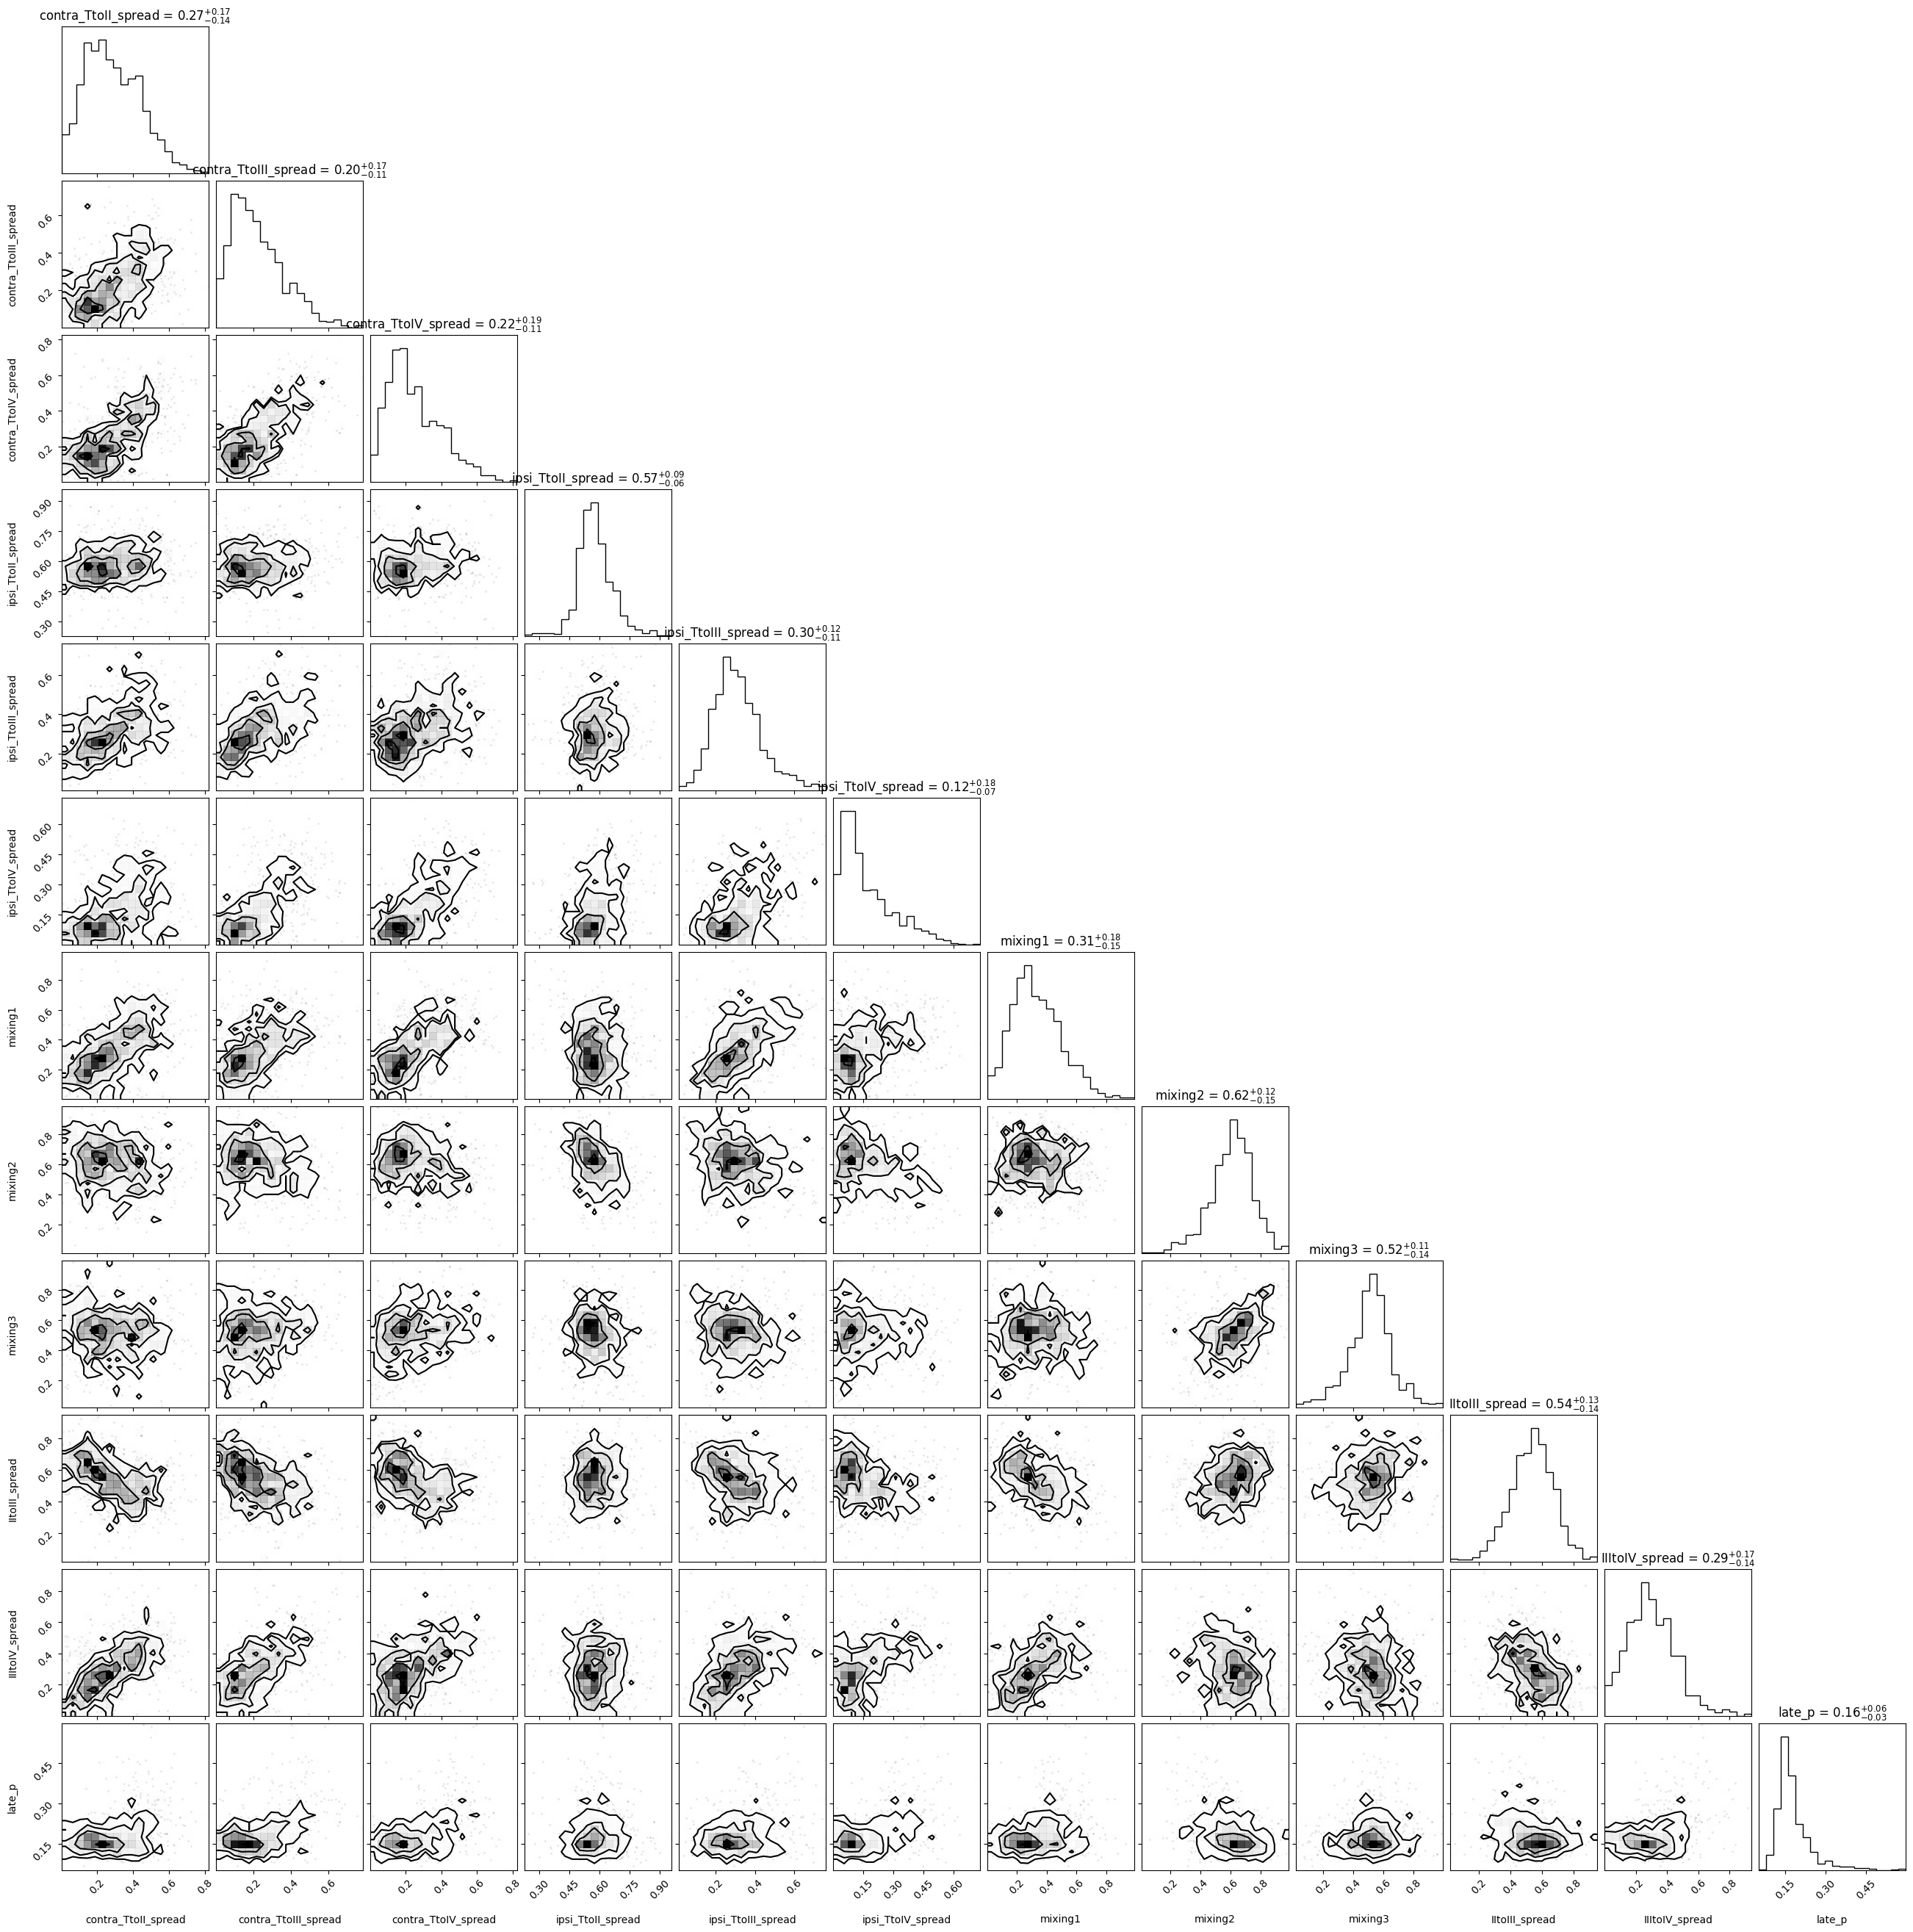

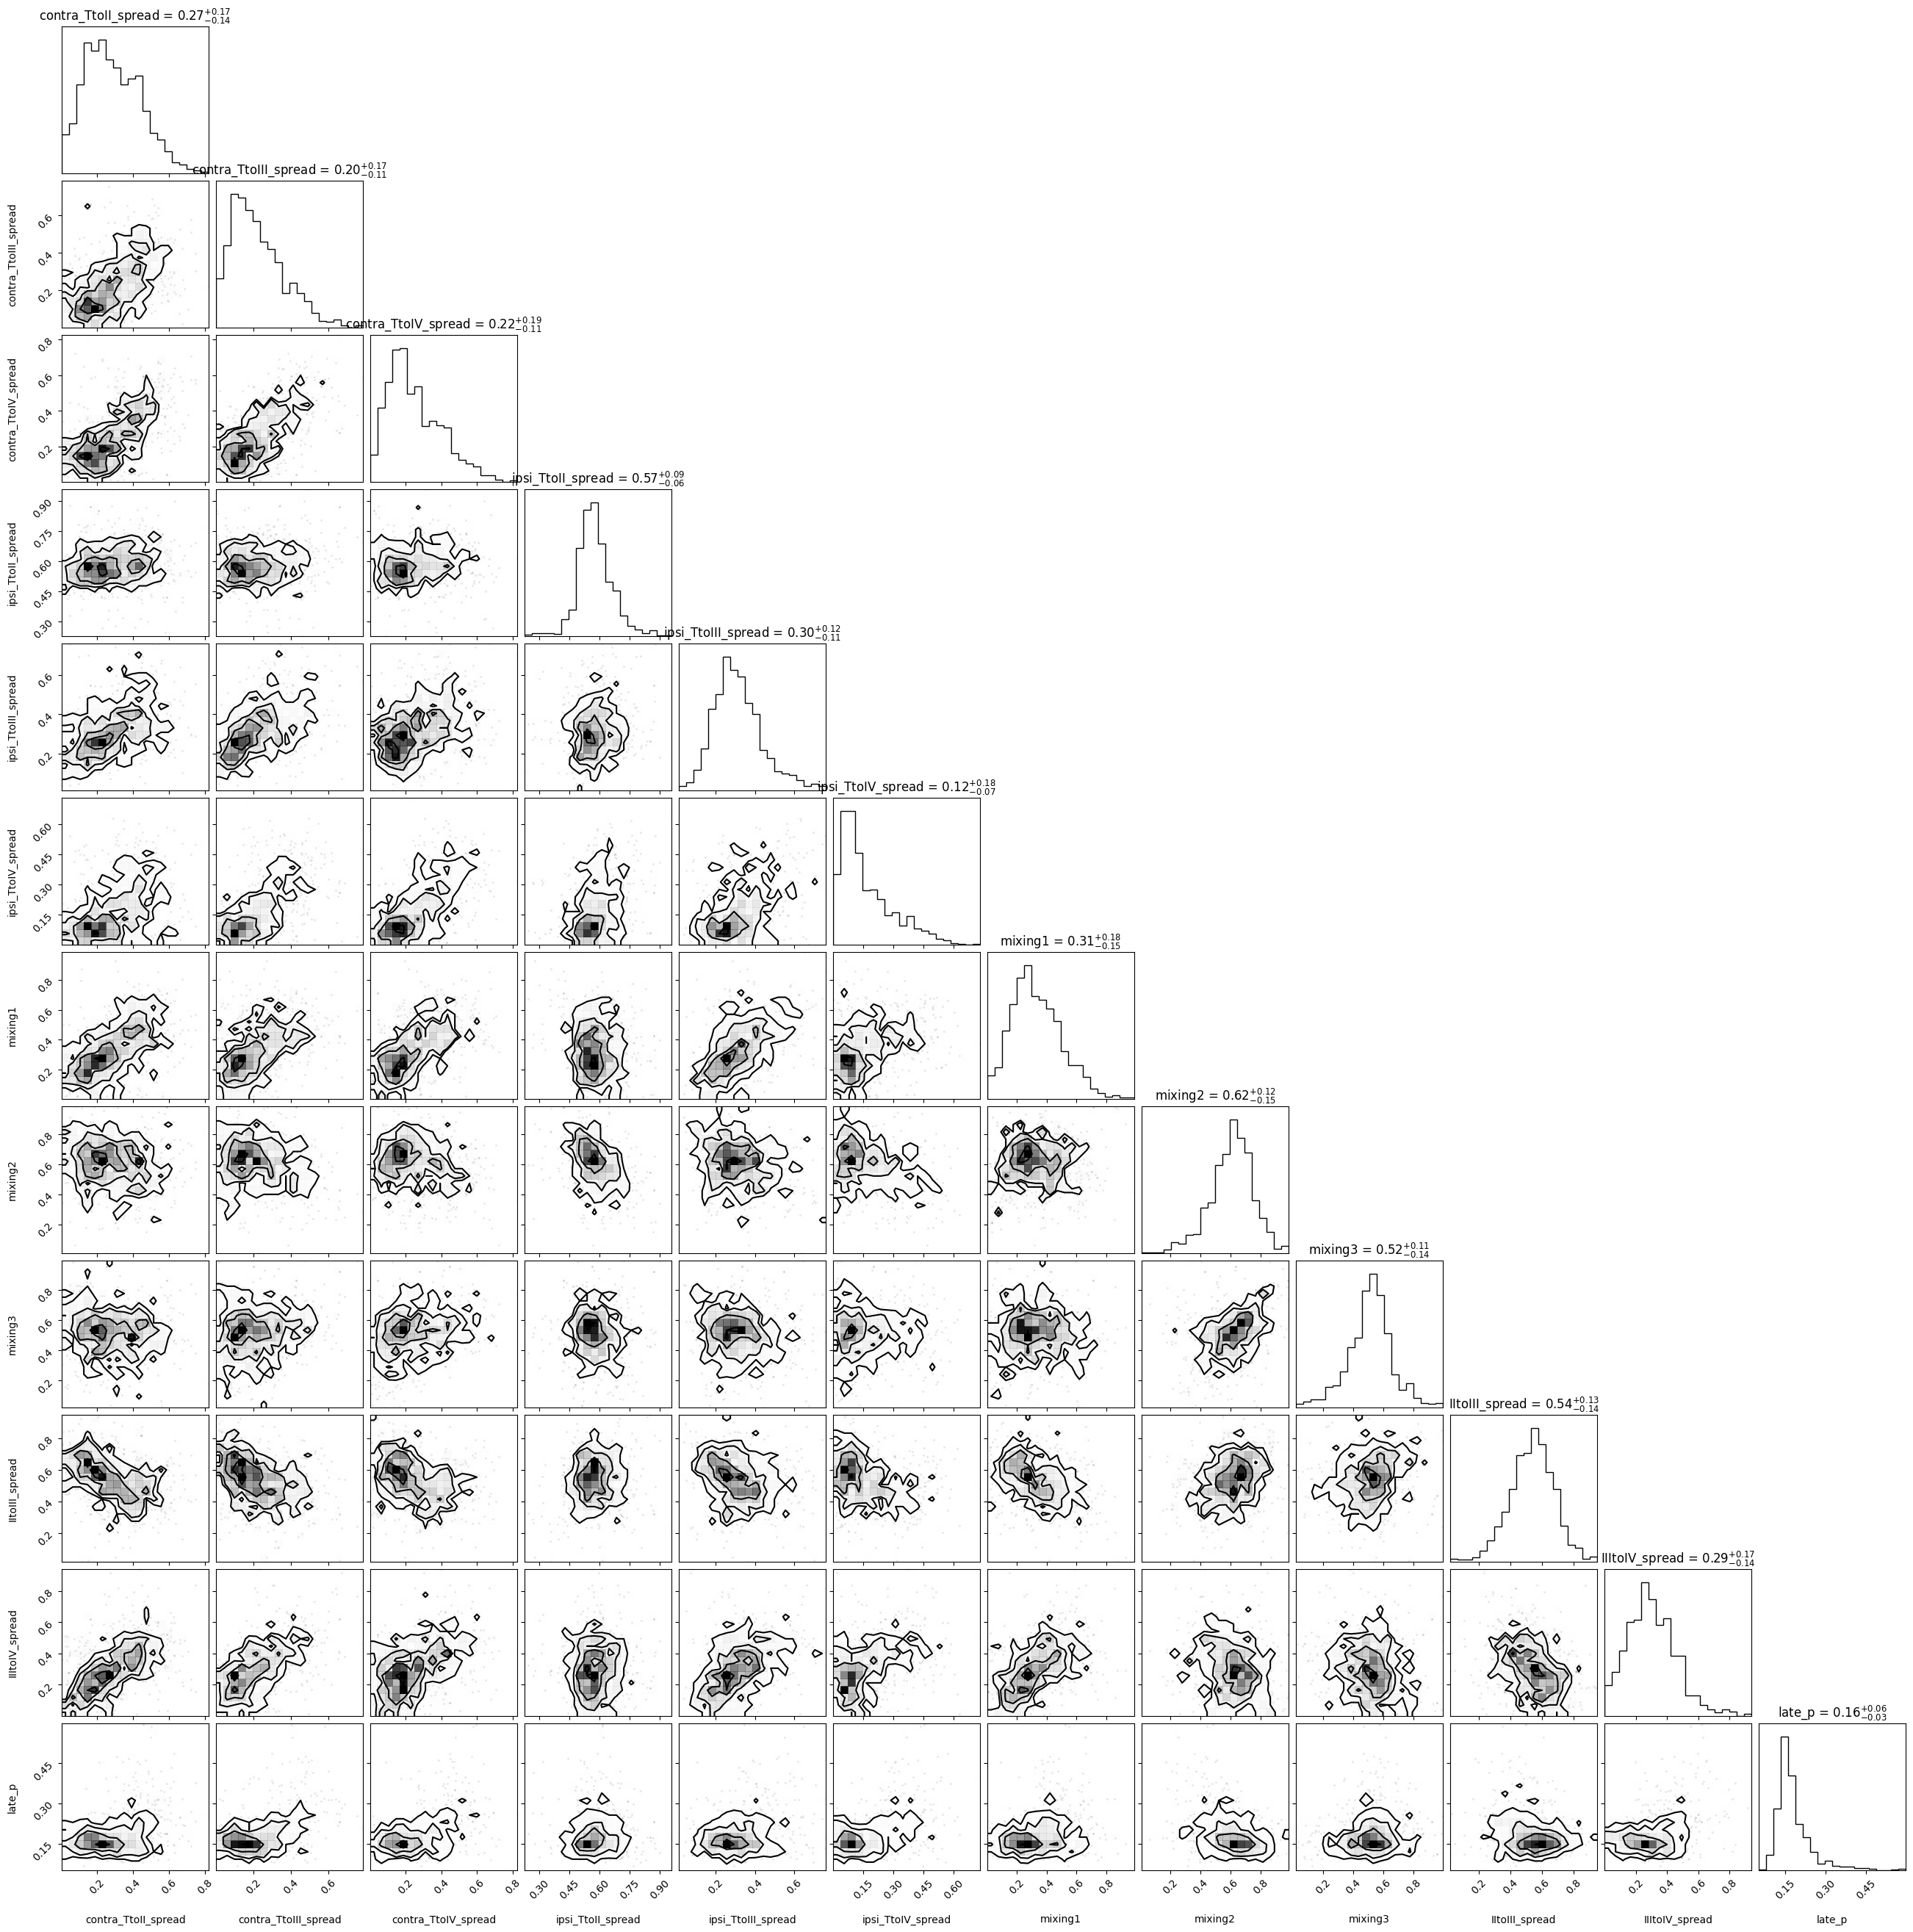

In [15]:
import corner

samples = sampler.get_chain(discard=int(0.1 * nsteps), flat=True, thin = 10)
corner.corner(samples, labels=list(model.get_params().keys()), show_titles=True, )

In [16]:

param_values = samples.mean(axis = 0)

params_to_set = {key: value for key, value in zip(list(model.get_params().keys()), param_values)}
model.set_params(**params_to_set)
model.likelihood()

np.float64(-661.0303406472971)

In [ ]:
model.noext.likelihood()

np.float64(-122.93611680661027)

In [ ]:
model.ext1.likelihood()

np.float64(-129.98188333731784)

In [ ]:
model.ext2.likelihood()

np.float64(-110.58484485043053)

In [ ]:
model.ext3.likelihood()

np.float64(-52.76537433603143)

In [17]:
{key: round(value, 3) for key, value in model.get_params().items()}

{'contra_TtoII_spread': np.float64(0.29),
 'contra_TtoIII_spread': np.float64(0.225),
 'contra_TtoIV_spread': np.float64(0.251),
 'ipsi_TtoII_spread': np.float64(0.577),
 'ipsi_TtoIII_spread': np.float64(0.314),
 'ipsi_TtoIV_spread': np.float64(0.168),
 'mixing1': np.float64(0.332),
 'mixing2': np.float64(0.606),
 'mixing3': np.float64(0.513),
 'IItoIII_spread': np.float64(0.536),
 'IIItoIV_spread': np.float64(0.303),
 'late_p': np.float64(0.181)}

In [26]:
# fix your seed for reproducibility
seed = 42
rng  = np.random.default_rng(seed)

# grab the names & initial *length*
init_dict   = model.get_params(as_dict=True)
param_names = list(init_dict.keys())
ndim        = len(param_names)
# draw a random starting point in [0,1]^ndim

x0 = rng.random(ndim)

for i, name in enumerate(param_names):
    print(f"{name} = {x0[i]:.3f}")
      

contra_TtoII_spread = 0.774
contra_TtoIII_spread = 0.439
contra_TtoIV_spread = 0.859
ipsi_TtoII_spread = 0.697
ipsi_TtoIII_spread = 0.094
ipsi_TtoIV_spread = 0.976
mixing1 = 0.761
mixing2 = 0.786
mixing3 = 0.128
IItoIII_spread = 0.450
IIItoIV_spread = 0.371
late_p = 0.927


In [ ]:
# # 1) grab the names & initial values
# #init_dict = model.get_params(as_dict=True)
# param_names = list(init_dict.keys())
# #x0 = np.array(list(init_dict.values()))

# # 2) negative log‐likelihood objective
# def neg_loglik(x: np.ndarray) -> float:
#     # map back to named params
#     p = dict(zip(param_names, x))
#     ll = model.likelihood(given_params=p, log=True)
#     # penalty if invalid
#     return -ll if np.isfinite(ll) else 1e8
# bounds = [(0.0, 1.0)] * ndim

# # for i, name in enumerate(param_names):
# #     if name == "late_p":
# #         bounds[i] = (0.3, 1.0)
# # 3) run optimization
# method = "Powell"
# #method = "Nelder-Mead"  # or "Powell", "L-BFGS-B", etc.
# res = minimize(
#     fun=neg_loglik,
#     x0=x0,
#     bounds=bounds,
#     method=method,
#     options={"maxiter": 1000, "disp": True},
# )

# # 4) unpack & load optimized params
# opt_x = res.x
# opt_params = dict(zip(param_names, opt_x))
# model.set_params(**opt_params)

# print("Powell optimize success:", res.success, res.message)
# print("Optimized parameters:")
# params_rounded = {k: round(float(v), 4) for k, v in model.get_params(as_dict=True).items()}
# pprint.pprint(params_rounded)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'